**Introduction**

* This kernel is a detailed guide for transfer learning on Dog Breeds problem, it's all about learning a new technique, evaluate it using only Kaggle training set without cheating.

* The aim of this kernel is to show you how to use pre-trained CNN models as feature extractors, which one of the most effective transfer learning techniques.

* A reasonable question comes to your mind, 'Wait, why do we have to use this technique, why don't we just use regular transfer learning ?', if you try to do so, you will figure out that the problem is pretty hard for a single model to handle (you would get higher loss and less accuracy).

* It's even hard for humankind to distinguish between 120 dog breeds!, single poor CNN would struggle.

**Explanation**

* Take look at general CNN architecture for image classification in two main parts, “feature extractor” that based on conv-layers, and “classifier” which usually based on fully connected layers:

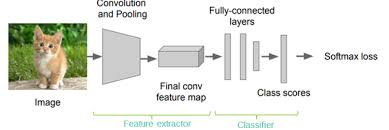

* Simply, feature extractor could be created as follow > (Feature Extractor = Pretrained Model - Late Fully Connected Layers)

* For example, InceptionV3 feature extractor (without last FC layer) outputs 2048 vector for each image sample, each value represent a certain feature of dog image (Coded in numerical values of course), like Dog color?, How big is his head?, Shape of the eyes?, length of the tale?, Size? .. etc

* Hence, more "different" feature extractors mean more features to be used to determine which breed does this dog belong.

* So our strategy goes as the following,
  1. Create 4 feature extractor using different pre-trained CNN models
  2. Extract features from raw data and stacks the features together.
  3. Use a simple DNN with one dense layer and a heavy dropout layer to figure out patterns in the feature extracted from the data.
     
     
* The code is simple, concise and fully-commented. Feel free to ask for help / more info / more explanation in the comments.

* Finally if this kernel helps you somehow, kindly don't forget to leave a little upvote.

* ENJOY.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 
import json
import os
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
#Data Paths
train_dir = '/kaggle/input/dog-breed-identification/train/'
test_dir = '/kaggle/input/dog-breed-identification/test/'
#Count/Print train and test samples.


In [ ]:
#Read train labels.
labels_dataframe = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
#Read sample_submission file to be modified by pridected labels.
# sample_df = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
#Incpect labels_dataframe.
labels_dataframe.head(5)

In [ ]:
#Create list of alphabetically sorted labels.
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:10]

In [ ]:
# with open('/kaggle/working/dog_breeds.json', 'w') as fp:
#     json.dump(dog_breeds,fp)

In [ ]:
#Map each label string to an integer label.
class_to_num = dict(zip(dog_breeds, range(n_classes)))
class_to_num

In [ ]:
class_to_num['toy_poodle']

In [ ]:
# with open('/kaggle/working/class_to_num.json', 'w') as fp:
#     json.dump(class_to_num,fp)

In [ ]:
labels_dataframe['file_name'] = labels_dataframe['id'].apply(lambda x:train_dir+f"{x}.jpg")

In [ ]:
labels_dataframe.head(5)['file_name'][0]

In [ ]:
labels_dataframe.head()

In [ ]:
codes = []
for index, data in labels_dataframe.iterrows():
    breed = data['breed']
    codes.append(class_to_num[breed])

In [ ]:
codes

In [ ]:
y = to_categorical(codes) # encoded our features 

In [ ]:
y

#### Model

In [ ]:
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as resnet_preprocess
# from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
# from keras.applications.xception import Xception, preprocess_input as xception_preprocess
# from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocess
# from keras.layers.merge import concatenate

# input_shape = (331,331,3)
# input_layer = Input(shape=input_shape)


# #first extractor inception_resnet
# preprocessor_resnet = Lambda(resnet_preprocess)(input_layer)
# inception_resnet = InceptionResNetV2(weights = 'imagenet',
#                                      include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_resnet)

# # second extractor InceptionV3
# preprocessor_inception = Lambda(inception_preprocess)(input_layer)
# inception_v3 = InceptionV3(weights = 'imagenet',
#                                      include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_inception)
# # Third extractor Xception
# preprocessor_xception = Lambda(xception_preprocess)(input_layer)
# xception = Xception(weights = 'imagenet',
#                                      include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_xception)

# # fourth extractor nasnet large
# preprocessor_nasnet = Lambda(nasnet_preprocess)(input_layer)
# nasnet = NASNetLarge(weights = 'imagenet',
#                                      include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_nasnet)


# merge = concatenate([inception_v3, xception,nasnet,inception_resnet])
# model = Model(inputs = input_layer, output = merge)


# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as resnet_preprocess
# from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetMobile, preprocess_input as nasnet_preprocess
from keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess
# from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input as resnet_v2_preprocess
from keras.layers.merge import concatenate
from keras.layers import Input,Lambda
from keras.models import Model

input_shape = (224,224,3)
input_layer = Input(shape=input_shape)


#first extractor resnet50v2
preprocessor_resnet = Lambda(resnet_v2_preprocess)(input_layer)
resnet = ResNet50V2(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_resnet)

# second extractor densenet
preprocessor_inception = Lambda(densenet_preprocess)(input_layer)
densenet = DenseNet121(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_inception)
# # Third extractor nasnet
preprocessor_xception = Lambda(nasnet_preprocess)(input_layer)
nasnet = NASNetMobile(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_xception)
# Third extractor Xception
# preprocessor_xception = Lambda(xception_preprocess)(input_layer)
# xception = Xception(weights = 'imagenet',
#                                      include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_xception)
# # # # fourth extractor nasnet large
# preprocessor_nasnet = Lambda(nasnet_preprocess)(input_layer)
# nasnet = NASNetLarge(weights = 'imagenet',
#                                      include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_nasnet)


merge = concatenate([resnet,nasnet,densenet])
model = Model(inputs = input_layer, outputs = merge)

In [ ]:
model.save('/kaggle/working/feature_extractor.h5')

In [ ]:
v= model.output.shape[1:]
print(v)

In [ ]:
print(v)

## Feature extraction of data not labels

In [ ]:
# for feature_extraction dataframe must have to contain file_name and  breed columns
def feature_extractor(df):
    img_size = (224,224,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,4128], dtype=np.uint8)
#     y = np.zeros([data_size,120], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,
    x_col = 'file_name', class_mode = None, 
    batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
           break
    return X
        
    

In [ ]:
X = feature_extractor(labels_dataframe)

In [ ]:
labels_dataframe

In [ ]:
X.shape

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/checkpoing',
                             monitor = 'val_loss',mode = 'min',save_best_only= True)
lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 3,min_lr = 0.00001)
my_callback=[EarlyStop_callback,checkpoint]

In [ ]:
dnn = keras.models.Sequential([
    InputLayer(X.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(X , y,
            batch_size=128,
            epochs=60,
            validation_split=0.1 ,
           callbacks = my_callback)

### Plot the Result 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
# ax2.set_xticks(np.arange(1, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 0.1))
plt.show()

### Saving and loading the model 

In [ ]:

from keras.models import load_model
dnn.save('/kaggle/working/dogbreed.h5')

# saved_model = load_model('/kaggle/working/dogbreed.h5')


## Prediction of the Test Data

In [ ]:

test_data = []
for pic in os.listdir(test_dir):
    test_data.append(test_dir+pic)

In [ ]:
test_data

In [ ]:
test_dataframe = pd.DataFrame({'file_name':test_data})

In [ ]:
test_dataframe

In [ ]:
test_features = feature_extractor(test_dataframe)

In [ ]:
y_pred = dnn.predict(test_features)

In [ ]:
y_pred.shape

In [ ]:
def get_key(val): 
        for key, value in class_to_num.items(): 
         if val == value: 
             return key 
            
pred_codes = np.argmax(y_pred, axis = 1)
pred_codes
    

In [ ]:
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))

In [ ]:
predictions

In [ ]:
test_dataframe['breed'] = predictions

In [ ]:
test_dataframe

### Drawing some images 

In [ ]:

plt.figure(figsize=(6,6))

for index , data in test_dataframe[:10].iterrows():
    img = data['file_name']
    label = data['breed']
    img = cv2.imread(img)
#     plt.subplot(2,5, index+1)
    plt.imshow(img)
    plt.xlabel(label,fontsize = (15))
    plt.tight_layout()
    plt.show()
    
